In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import librosa
from pathlib import Path
from torch.utils.data import Dataset, DataLoader


In [3]:
DATA_ROOT = Path(r"C:\Users\Abdul\OneDrive\Desktop\Varsity\Deep Learning\Dataset")
asv2019_root = DATA_ROOT / "ASVSpoof2019" / "LA" / "LA"

train_dir = asv2019_root / "ASVspoof2019_LA_train"
dev_dir   = asv2019_root / "ASVspoof2019_LA_dev"
eval_dir  = asv2019_root / "ASVspoof2019_LA_eval"

proto_dir = asv2019_root / "ASVspoof2019_LA_cm_protocols"

train_proto = proto_dir / "ASVspoof2019.LA.cm.train.trn.txt"
dev_proto   = proto_dir / "ASVspoof2019.LA.cm.dev.trl.txt"
eval_proto  = proto_dir / "ASVspoof2019.LA.cm.eval.trl.txt"


In [4]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}

def parse_protocol(proto_path, base_dir):
    """
    Parse ASVspoof2019 LA CM protocol file.

    Lines typically look like:
      LA_0065 LA_T_1000135 - bonafide
      LA_0065 LA_T_1000137 A01 spoof

    So:
      - file_id is parts[1]
      - 'bonafide' or 'spoof' appears somewhere in the line
      - attack_id is something like 'A01' or '-'
    """
    entries = []
    with open(proto_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            parts = line.split()

            # 1) file_id (2nd token)
            file_id = parts[1]

            # 2) label token: 'bonafide' or 'spoof'
            label_token = None
            for p in parts:
                if p in LABEL_MAP:
                    label_token = p
                    break
            if label_token is None:
                # No bonafide/spoof in this line → skip
                # (shouldn't really happen, but safe)
                continue

            # 3) attack/system ID: token like 'A01', 'A10', or '-'
            attack_id = "-"
            for p in parts:
                if p.startswith("A") or p == "-":
                    attack_id = p
                    break

            # 4) Build path from file_id
            rel_path = file_id + ".flac"
            audio_path = base_dir / "flac" / rel_path

            entries.append((audio_path, LABEL_MAP[label_token], attack_id))

    print(f"Parsed {len(entries)} entries from {proto_path.name}")
    return entries



In [5]:
def pad_or_truncate_waveform(y, target_len=96000):
    if len(y) < target_len:
        pad_width = target_len - len(y)
        y_fixed = np.pad(y, (0, pad_width), mode='constant')
    else:
        y_fixed = y[:target_len]
    return y_fixed


In [6]:
class ASVspoof2019LADataset(Dataset):
    def __init__(self, split="train"):
        assert split in {"train", "dev", "eval"}
        
        if split == "train":
            self.base_dir = train_dir
            self.proto_path = train_proto
        elif split == "dev":
            self.base_dir = dev_dir
            self.proto_path = dev_proto
        else:
            self.base_dir = eval_dir
            self.proto_path = eval_proto

        self.entries = parse_protocol(self.proto_path, self.base_dir)
        print(f"{split} split: {len(self.entries)} files")

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        audio_path, label, attack_id = self.entries[idx]

        y, sr = librosa.load(audio_path, sr=16000)
        y = pad_or_truncate_waveform(y, target_len=96000)
        y = (y - np.mean(y)) / (np.std(y) + 1e-6)

        audio_tensor = torch.from_numpy(y).float().unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return audio_tensor, label_tensor


In [7]:
batch_size = 4

train_dataset = ASVspoof2019LADataset(split="train")
dev_dataset   = ASVspoof2019LADataset(split="dev")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dev_loader   = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Parsed 25380 entries from ASVspoof2019.LA.cm.train.trn.txt
train split: 25380 files
Parsed 24844 entries from ASVspoof2019.LA.cm.dev.trl.txt
dev split: 24844 files


**Training RAWNet-Mini Style residual Block**

In [9]:
class ResBlock1D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(channels)
        self.act   = nn.LeakyReLU(0.3, inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + residual
        out = self.act(out)
        return out


In [10]:
class RawNetMini(nn.Module):
    """
    A simplified RawNet-style model for ASVspoof2019 LA.
    Input: [B, 1, T] raw waveform (T ≈ 96000)
    """
    def __init__(self, n_classes=2):
        super().__init__()
        self.act = nn.LeakyReLU(0.3, inplace=True)

        # Front-end: heavily downsample time with strided conv + pooling
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=1)  # T -> T/3
        self.bn1   = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)                  # T/3 -> T/9

        # Residual block stack + another pool
        self.res1  = ResBlock1D(128)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=3)                  # T/9 -> T/27

        self.res2  = ResBlock1D(128)

        # GRU encoder over time
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=False,
        )

        # Final classifier
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        """
        x: [B, 1, T]
        """
        # Front end
        x = self.conv1(x)   # [B, 128, T/3]
        x = self.bn1(x)
        x = self.act(x)
        x = self.pool1(x)   # [B, 128, T/9]

        x = self.res1(x)    # [B, 128, T/9]
        x = self.pool2(x)   # [B, 128, T/27]

        x = self.res2(x)    # [B, 128, T/27]

        # Prepare for GRU: [B, C, T] -> [B, T, C]
        x = x.transpose(1, 2)   # [B, T_seq, 128]

        # GRU encoder
        out, h_n = self.gru(x)  # h_n: [num_layers, B, 128]

        # Use final hidden state from top GRU layer
        h_last = h_n[-1]        # [B, 128]

        logits = self.fc(h_last)  # [B, n_classes]
        return logits


**THIS PART DOES NOT WORK**

In [14]:
model = RawNetMini(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [15]:
from torch.nn.utils import clip_grad_norm_

def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=5.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for audio_batch, labels in loader:
        # audio_batch: [B, 1, T]
        audio_batch = audio_batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_batch)        # [B, 2]
        loss = criterion(outputs, labels)

        loss.backward()
        # gradient clipping (helps with GRU stability)
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * audio_batch.size(0)

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)
            labels = labels.to(device)

            outputs = model(audio_batch)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * audio_batch.size(0)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


In [ ]:
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    dev_loss, dev_acc = eval_one_epoch(model, dev_loader, criterion, device)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Dev:   loss={dev_loss:.4f}, acc={dev_acc:.4f}")
"""
The model is broken: means training blew up after epoch 1 – the model’s outputs or gradients went unstable, so the loss became NaN and everything collapsed after that.

That usually happens because of exploding values somewhere (big gradients, aggressive normalization, long sequences, etc.).
"""

In [17]:
torch.save(model.state_dict(), "rawnet_mini_asv2019LA.pth")


In [18]:
eval_dataset = ASVspoof2019LADataset(split="eval")
eval_loader  = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=0)


Parsed 71237 entries from ASVspoof2019.LA.cm.eval.trl.txt
eval split: 71237 files


In [8]:
import numpy as np

def evaluate(model, loader, device):
    model.eval()
    all_labels = []
    all_scores = []  # spoof probabilities

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)   # [B, 1, T]
            labels = labels.to(device)             # [B]

            logits = model(audio_batch)            # [B, 2]
            probs = torch.softmax(logits, dim=1)   # [B, 2]
            spoof_scores = probs[:, 1]             # prob of class 1 = spoof

            all_scores.extend(spoof_scores.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_scores)


In [20]:
!pip install scikit-learn

In [21]:
from sklearn.metrics import accuracy_score, roc_curve

# Get labels + scores from model
eval_labels, eval_scores = evaluate(model, eval_loader, device)

# Accuracy at 0.5 threshold
pred = (eval_scores >= 0.5).astype(int)
acc = accuracy_score(eval_labels, pred)
print("Eval Accuracy:", acc)

# EER (Equal Error Rate)
fpr, tpr, thr = roc_curve(eval_labels, eval_scores)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
print("Eval EER:", eer)


Eval Accuracy: 0.10324690820781336


ValueError: Input contains NaN.

**NEW MODEL**

In [9]:
from torch.nn.utils import clip_grad_norm_


In [10]:
def __getitem__(self, idx):
    audio_path, label, attack_id = self.entries[idx]

    y, sr = librosa.load(audio_path, sr=16000)

    # 1) pad/truncate
    y = pad_or_truncate_waveform(y, target_len=64000)  # shorter => more stable, less GPU load

    # 2) safer normalization
    mean = np.mean(y)
    std = np.std(y)
    y = (y - mean) / (std + 1e-3)    # larger epsilon

    # 3) clip extreme values
    y = np.clip(y, -3.0, 3.0)

    audio_tensor = torch.from_numpy(y).float().unsqueeze(0)  # [1, T]
    label_tensor = torch.tensor(label, dtype=torch.long)

    return audio_tensor, label_tensor


In [18]:
model = RawNetMini(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # was 1e-3


In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=3.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (audio_batch, labels) in enumerate(loader):
        audio_batch = audio_batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_batch)
        loss = criterion(outputs, labels)

        # NaN guard
        if not torch.isfinite(loss):
            print(f"[WARN] Non-finite loss at batch {batch_idx}, loss={loss.item()}")
            return float("nan"), 0.0

        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * audio_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [12]:
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)
            labels = labels.to(device)

            outputs = model(audio_batch)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * audio_batch.size(0)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [22]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    dev_loss, dev_acc = eval_one_epoch(model, dev_loader, criterion, device)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Dev:   loss={dev_loss:.4f}, acc={dev_acc:.4f}")


Epoch 1/5
  Train: loss=0.3206, acc=0.8983
  Dev:   loss=0.3300, acc=0.8974
Epoch 2/5
  Train: loss=0.3145, acc=0.8983
  Dev:   loss=0.3291, acc=0.8974
Epoch 3/5
  Train: loss=0.3109, acc=0.8983
  Dev:   loss=0.3497, acc=0.8974
Epoch 4/5
  Train: loss=0.3077, acc=0.8983
  Dev:   loss=0.3371, acc=0.8974
Epoch 5/5
  Train: loss=0.3067, acc=0.8983
  Dev:   loss=0.3291, acc=0.8974


In [23]:
# Save the final trained model
torch.save(model.state_dict(), "rawnet_mini_last.pth")
print("Saved model to rawnet_mini_last.pth")


Saved model to rawnet_mini_last.pth


In [24]:
eval_dataset = ASVspoof2019LADataset(split="eval")
eval_loader  = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=0)


Parsed 71237 entries from ASVspoof2019.LA.cm.eval.trl.txt
eval split: 71237 files


In [13]:
import numpy as np

def evaluate(model, loader, device):
    model.eval()
    all_labels = []
    all_scores = []  # spoof probabilities

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)
            labels = labels.to(device)

            logits = model(audio_batch)              # [B, 2]
            probs = torch.softmax(logits, dim=1)     # [B, 2]
            spoof_scores = probs[:, 1]              # prob(class=1 = spoof)

            all_scores.extend(spoof_scores.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_scores)


In [26]:
from sklearn.metrics import accuracy_score, roc_curve

# If you want to be extra safe, you can reload the saved model:
# best_model = RawNetMini(n_classes=2).to(device)
# best_model.load_state_dict(torch.load("rawnet_mini_last.pth", map_location=device))
# model_to_eval = best_model

# Or just evaluate the current model in memory:
model_to_eval = model

eval_labels, eval_scores = evaluate(model_to_eval, eval_loader, device)

# Accuracy at 0.5 threshold
pred = (eval_scores >= 0.5).astype(int)
acc = accuracy_score(eval_labels, pred)
print("Eval Accuracy:", acc)

# EER (Equal Error Rate)
fpr, tpr, thr = roc_curve(eval_labels, eval_scores)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
print("Eval EER:", eer)


Eval Accuracy: 0.8967530917921867
Eval EER: 0.48198504418762744


**RAW NET 2**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlockRawNet2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm1d(out_channels)

        # If channels or stride differ, use a 1x1 conv on the skip path
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.act = nn.LeakyReLU(0.3, inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)

        out = out + shortcut
        out = self.act(out)
        return out


In [10]:
class RawNet2(nn.Module):
    """
    RawNet2-style architecture (simplified) for ASVspoof2019 LA.
    Input: [B, 1, T] raw waveform (e.g. T = 64000)
    """
    def __init__(self, n_classes=2):
        super().__init__()
        self.act = nn.LeakyReLU(0.3, inplace=True)

        # Front-end conv (no SincConv here, but similar idea)
        self.conv_in = nn.Conv1d(1, 64, kernel_size=3, stride=3, padding=1, bias=False)
        self.bn_in   = nn.BatchNorm1d(64)

        # Residual block stack with progressive downsampling
        self.block1 = ResBlockRawNet2(64, 64, stride=1)   # keep length
        self.block2 = ResBlockRawNet2(64, 128, stride=3)  # T -> T/3
        self.block3 = ResBlockRawNet2(128, 128, stride=3) # T/3 -> T/9
        self.block4 = ResBlockRawNet2(128, 256, stride=3) # T/9 -> T/27
        self.block5 = ResBlockRawNet2(256, 256, stride=1) # keep length

        # GRU encoder over time
        self.gru = nn.GRU(
            input_size=256,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=False,
        )

        # Final classifier from last GRU hidden state
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        """
        x: [B, 1, T]
        """
        # Front-end conv + nonlinearity
        x = self.conv_in(x)     # [B, 64, T/3]
        x = self.bn_in(x)
        x = self.act(x)

        # Residual blocks
        x = self.block1(x)      # [B, 64, T/3]
        x = self.block2(x)      # [B, 128, ~T/9]
        x = self.block3(x)      # [B, 128, ~T/27]
        x = self.block4(x)      # [B, 256, ~T/81]
        x = self.block5(x)      # [B, 256, ~T/81]

        # Prepare for GRU: [B, C, T'] -> [B, T', C]
        x = x.transpose(1, 2)   # [B, T_seq, 256]

        # GRU
        out, h_n = self.gru(x)  # h_n: [num_layers, B, 256]
        h_last = h_n[-1]        # [B, 256]

        logits = self.fc(h_last)  # [B, n_classes]
        return logits


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = RawNet2(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


Using device: cuda


In [14]:
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)
            labels = labels.to(device)

            outputs = model(audio_batch)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * audio_batch.size(0)

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=3.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (audio_batch, labels) in enumerate(loader):
        audio_batch = audio_batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_batch)
        loss = criterion(outputs, labels)

        # NaN guard
        if not torch.isfinite(loss):
            print(f"[WARN] Non-finite loss at batch {batch_idx}, loss={loss.item()}")
            return float("nan"), 0.0

        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        running_loss += loss.item() * audio_batch.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [14]:
from torch.nn.utils import clip_grad_norm_

num_epochs = 5
best_dev_loss = float("inf")
best_model_path = "rawnet2_best.pth"

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    dev_loss, dev_acc = eval_one_epoch(model, dev_loader, criterion, device)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.4f}")
    print(f"  Dev:   loss={dev_loss:.4f}, acc={dev_acc:.4f}")

    if dev_loss < best_dev_loss and np.isfinite(dev_loss):
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best model saved to {best_model_path} (dev_loss={dev_loss:.4f})")


Epoch 1/5
  Train: loss=0.3285, acc=0.8983
  Dev:   loss=0.3569, acc=0.8974
  ✅ New best model saved to rawnet2_best.pth (dev_loss=0.3569)
Epoch 2/5
  Train: loss=0.3284, acc=0.8983
  Dev:   loss=0.3281, acc=0.8974
  ✅ New best model saved to rawnet2_best.pth (dev_loss=0.3281)
Epoch 3/5
  Train: loss=0.3251, acc=0.8983
  Dev:   loss=0.3422, acc=0.8974
Epoch 4/5
  Train: loss=0.3215, acc=0.8983
  Dev:   loss=0.2874, acc=0.8974
  ✅ New best model saved to rawnet2_best.pth (dev_loss=0.2874)
Epoch 5/5
  Train: loss=0.1370, acc=0.9522
  Dev:   loss=0.0987, acc=0.9719
  ✅ New best model saved to rawnet2_best.pth (dev_loss=0.0987)


In [16]:
import numpy as np

def evaluate(model, loader, device):
    model.eval()
    all_labels = []
    all_scores = []  # spoof probabilities

    with torch.inference_mode():
        for audio_batch, labels in loader:
            audio_batch = audio_batch.to(device)
            labels = labels.to(device)

            logits = model(audio_batch)               # [B, 2]
            probs = torch.softmax(logits, dim=1)      # [B, 2]
            spoof_scores = probs[:, 1]                # probability of spoof class

            all_scores.extend(spoof_scores.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_scores)


In [22]:
# Build eval dataset + loader
eval_dataset = ASVspoof2019LADataset(split="eval")

eval_loader  = DataLoader(
    eval_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

print("Eval samples:", len(eval_dataset))


Parsed 71237 entries from ASVspoof2019.LA.cm.eval.trl.txt
eval split: 71237 files
Eval samples: 71237


In [23]:
# Reload best RawNet2 model
best_model = RawNet2(n_classes=2).to(device)
best_model.load_state_dict(torch.load("rawnet2_best.pth", map_location=device))

eval_labels, eval_scores = evaluate(best_model, eval_loader, device)

pred = (eval_scores >= 0.5).astype(int)
acc = accuracy_score(eval_labels, pred)
print("RawNet2 Eval Accuracy:", acc)

fpr, tpr, thr = roc_curve(eval_labels, eval_scores)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
print("RawNet2 Eval EER:", eer)


C:\Users\Abdul\AppData\Local\Temp\ipykernel_17284\2000248336.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("rawnet2_best.pth", ma

RawNet2 Eval Accuracy: 0.9180762805845277
RawNet2 Eval EER: 0.10292318150917742


Confusion matrix:
 [[ 5796  1559]
 [ 4277 59605]]


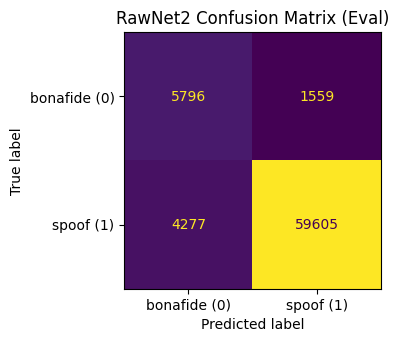

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Binary prediction at threshold 0.5
pred = (eval_scores >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(eval_labels, pred)
print("Confusion matrix:\n", cm)

# Optional: pretty plot
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["bonafide (0)", "spoof (1)"]
)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, values_format='d', colorbar=False)
plt.title("RawNet2 Confusion Matrix (Eval)")
plt.tight_layout()
plt.show()


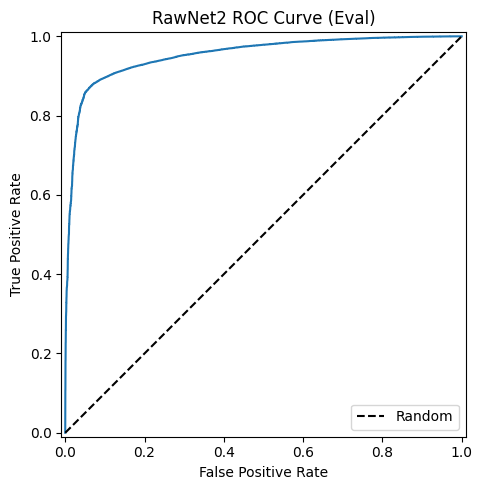

In [25]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(eval_labels, eval_scores)

# Basic ROC plot
fig, ax = plt.subplots(figsize=(5, 5))
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_disp.plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label="Random")
ax.set_title("RawNet2 ROC Curve (Eval)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


EER: 0.10292318150917742


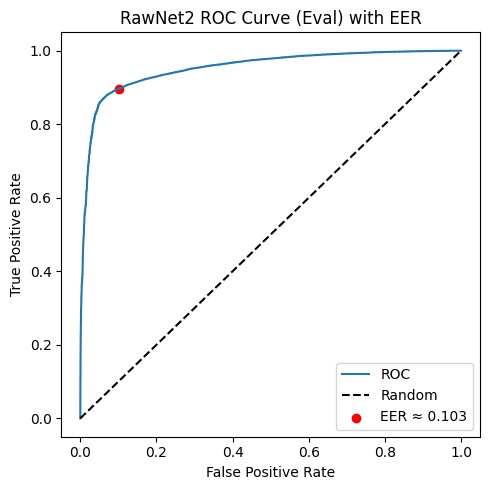

In [26]:
# Compute EER again
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer_fpr = fpr[eer_idx]
eer_tpr = tpr[eer_idx]
eer = fpr[eer_idx]
print("EER:", eer)

# Plot ROC with EER point highlighted
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1], 'k--', label="Random")
ax.scatter(eer_fpr, eer_tpr, color="red", label=f"EER ≈ {eer:.3f}")
ax.set_title("RawNet2 ROC Curve (Eval) with EER")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


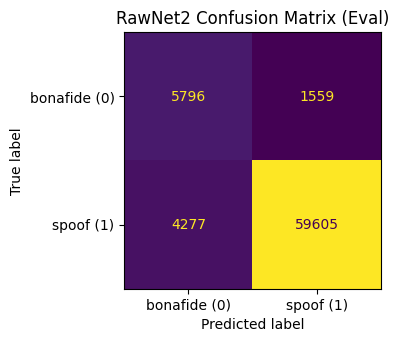

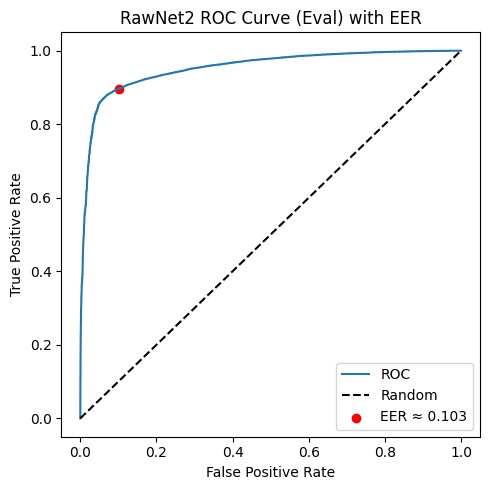

In [27]:
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bonafide (0)", "spoof (1)"])
disp.plot(ax=ax_cm, values_format='d', colorbar=False)
plt.title("RawNet2 Confusion Matrix (Eval)")
plt.tight_layout()
fig_cm.savefig("rawnet2_confusion_matrix_eval.png", dpi=300)

fig_roc, ax_roc = plt.subplots(figsize=(5, 5))
ax_roc.plot(fpr, tpr, label="ROC")
ax_roc.plot([0, 1], [0, 1], 'k--', label="Random")
ax_roc.scatter(eer_fpr, eer_tpr, color="red", label=f"EER ≈ {eer:.3f}")
ax_roc.set_title("RawNet2 ROC Curve (Eval) with EER")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
plt.tight_layout()
fig_roc.savefig("rawnet2_roc_eval.png", dpi=300)
